<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_31_preloaded_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained Embeddings notebook


In the previous notebook [2019-07-30_deep_learning_summary](https://github.com/sv650s/sb-capstone/blob/master/2019_07_30_deep_learning_summary.ipynb) we looked at the results for various deep learning models. There were 2 models that came back with the best results:

* 1 layer bi direcitonal GRU with attention
* 3 layer CNN with maxpooling - we train this with 15 epoch without early stopping

Overall, GRU model offered better precision however poor recall

CNN had a good balance for F1 (precision and recall) scores for class 2, 3, 4 - our problem classes, but did poorly for our class 1 and 5

In this notebook, we will use pre-trained word embeddings for both models. Idea is that in our previous notebooks, embeddings were random to start with and as we train the model as well as embeddings.

With pre-trained embeddings, we should see improvements in our model in term of training time since the embedding vectors are pre-trained


Pre-trained word vectors will come from Google's Word2Vec model pre-trained on Google News: https://github.com/mmihaltz/word2vec-GoogleNews-vectors

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"

# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, SpatialDropout1D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt


# custom utility functions
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku


sns.set()

import logging
logging.basicConfig(level=logging.INFO)

DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


Using TensorFlow backend.


In [3]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

''

In [0]:
df = pd.read_csv(f"{DATA_FILE}")
ratings = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

## Preprocessing our Data

In [5]:
from  keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence


# one hot encode our lables so we can pass it to our model later
print("One hot enocde label data...")
y = OneHotEncoder().fit_transform(ratings.values.reshape(len(ratings), 1)).toarray()

# split our data into train and test sets
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(reviews, y, random_state=1)

# Pre-process our features (review body)
t = Tokenizer(lower=True, oov_token="<UNK>")
# fit the tokenizer on the documents so that we can get word index dict - key = word, value = index of tokenizer
t.fit_on_texts(X_train)

# tokenize both our training and test data
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

# figure out 99% percentile for our max sequence length
df["feature_length"] = df.review_body.apply(lambda x: len(x.split()))
max_sequence_length = int(df.feature_length.quantile([0.99]).values[0])
print(f'Max Sequence Length: {max_sequence_length}')

# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=max_sequence_length)
X_test = sequence.pad_sequences(test_sequences, maxlen=max_sequence_length)

One hot enocde label data...
Splitting data into training and test sets...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


In [0]:
import numpy as np

def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    """
    This builds a matrix of word vectors that are in our vocabulary
    :return: matrix of word vectors - index is the index in our vocabulary, each row is the word vector    
    """
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')

    # turns the embedding file into a dictionary key = word, value = word vector
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    # convert the values into a array of word vectors
    all_embs = np.stack(embeddings_index.values())
    # get mean and std of embedding vectors so we can normalize them later
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    print(f'embed_size {embed_size}')
    print(f'max_features {max_features}')
    
    
    # nb_words = min(max_features, len(word_to_index))
    nb_words = max_features
    # print(f'({nb_words}, {embedding_size})')

    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    # loop through all words in our vocabulary
    for word, idx in word_to_index.items():
        if idx >= max_features - 1: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [8]:
# total umber of words in our corpus
# adding 1 because Embedding layer suggests that we pass in vocab size + 1
# the shape of the embedding matrix/weights need to match this
MAX_FEATURES = len(t.word_index) + 1
EMBED_SIZE = 300
pg_embeddings = load_pretrained_embeddings(word_to_index=t.word_index, max_features=MAX_FEATURES, 
                                            embedding_size=EMBED_SIZE, 
                                            embedding_file_path=f'{DRIVE_DIR}/data/paragram_300_sl999.txt')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


embed_size 300
max_features 40790


In [9]:
from itertools import islice
list(islice(t.word_index, 5))

print(max([value for key, value in list(t.word_index.items())]))
print(min([value for key, value in list(t.word_index.items())]))
len(pg_embeddings)

40789
1


40790

In [0]:
MODEL_NAME = "biGRU_1layer_attention-paragram"
EPOCHS  = 50
BATCH_SIZE = 128
GRU_DIM = 250 # total GRU units

In [11]:
print(f'Max Features: {MAX_FEATURES}')
print(f'max_sequence_length {max_sequence_length}')
print(f'pg_embeddings.shape {pg_embeddings.shape}')
print(f'EMBED_SIZE {EMBED_SIZE}')

Max Features: 40790
max_sequence_length 186
pg_embeddings.shape (40790, 300)
EMBED_SIZE 300


### Reusing our code from previous notebook that we put into utility class

For full source code for ModelWrapper and AttentionLayer, please look at [keras_util.py](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py)

In [13]:
from keras.layers import CuDNNGRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=2, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='auto', 
                           verbose=1,
                          restore_best_weights=True)


inp = keras.layers.Input(shape=(max_sequence_length,))
x = keras.layers.Embedding(MAX_FEATURES, 
                    EMBED_SIZE, 
                    input_length=max_sequence_length, 
                    weights=[pg_embeddings], trainable=True)(inp)
x = ku.AttentionLayer(max_sequence_length)(x)
x = keras.layers.Dense(GRU_DIM*2, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(GRU_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(5, activation='softmax')(x)
# initialize the model
model = keras.models.Model(inputs=inp, outputs=outp)
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


# wrap our model in our class so we can record metrics
mw = ku.ModelWrapper(model, MODEL_NAME, LABEL_COLUMN, DATA_FILE,
                     embedding=EMBED_SIZE,
                     tokenizer=t, description="Pre-trained Embedding - paragram")

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[reduce_lr, early_stop])


W0802 06:28:58.665066 140272738895744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 151s 2ms/step - loss: 1.0221 - acc: 0.6127 - val_loss: 0.9435 - val_acc: 0.6362
Epoch 2/50
67225/67225 [==============================] - 149s 2ms/step - loss: 0.8655 - acc: 0.6637 - val_loss: 0.8652 - val_acc: 0.6647
Epoch 3/50
67225/67225 [==============================] - 148s 2ms/step - loss: 0.8144 - acc: 0.6839 - val_loss: 0.8601 - val_acc: 0.6682
Epoch 4/50
67225/67225 [==============================] - 150s 2ms/step - loss: 0.7827 - acc: 0.6961 - val_loss: 0.8657 - val_acc: 0.6695
Epoch 5/50
67225/67225 [==============================] - 150s 2ms/step - loss: 0.7496 - acc: 0.7109 - val_loss: 0.8744 - val_acc: 0.6636
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


## Evaluate our Model

In [15]:
mw.evaluate(X_test, y_test)

Running model.evaluate...
28011/28011 [==============================] - 8s 288us/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...


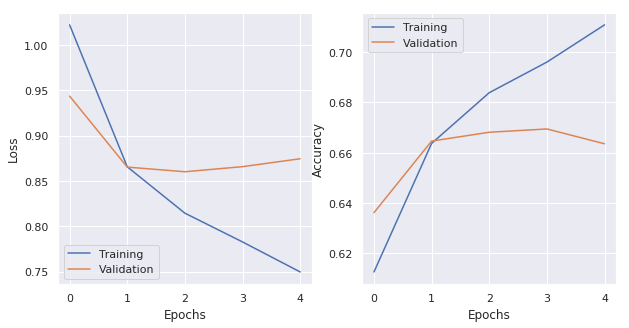

In [20]:
pu.plot_network_history(mw.network_history)

In [17]:
print(f'Accuracy: {mw.scores[1]}')

Accuracy: 0.668987183612824


In [18]:
mw.confusion_matrix

array([[ 3036,    83,   259,    78,   512],
       [  814,    77,   387,   180,   413],
       [  477,    61,   575,   639,   779],
       [  145,    23,   353,  1093,  3138],
       [  191,    10,   125,   605, 13958]])

In [19]:
print(mw.classification_report)

              precision    recall  f1-score   support

           1       0.65      0.77      0.70      3968
           2       0.30      0.04      0.07      1871
           3       0.34      0.23      0.27      2531
           4       0.42      0.23      0.30      4752
           5       0.74      0.94      0.83     14889

    accuracy                           0.67     28011
   macro avg       0.49      0.44      0.43     28011
weighted avg       0.61      0.67      0.62     28011



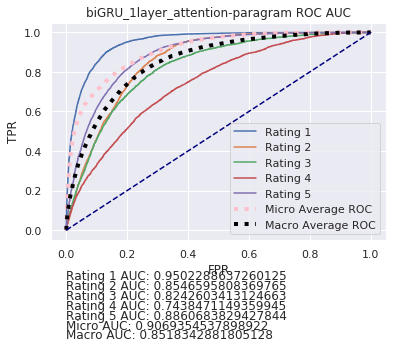

In [21]:
pu.plot_roc_auc(MODEL_NAME, mw.roc_auc, mw.fpr, mw.tpr)

In [23]:
mw.save(DRIVE_DIR, append_report=True)

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-biGRU_1layer_attention-paragram-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-biGRU_1layer_attention-paragram-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-biGRU_1layer_attention-paragram-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-08-02-dl_protype-report.csv
Saving report file...
